# Experiment 1 Notebook

This experiment is to test the plausability of using sentiment/embedings to automatically rate severity.


In [10]:
import nltk
from jiwer import wer
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.metrics import cohen_kappa_score


# NLTK's VADER
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# FLAIR's en-sentiment
from flair.models import TextClassifier
from flair.data import Sentence
flair_sent = TextClassifier.load('en-sentiment')


from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# bert nli is said to be depreciated
bert_nli = SentenceTransformer('bert-base-nli-mean-tokens')
mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
distil_roberta = SentenceTransformer('sentence-transformers/all-distilroberta-v1')


2023-01-31 09:24:42,525 loading file /Users/ryanwhetten/.flair/models/sentiment-en-mix-distillbert_4.pt


In [13]:
wer('I love you', 'I loathe you')

0.3333333333333333

In [14]:
wer('I love you', 'I luv you')

0.3333333333333333

## Read in Ratings

In [13]:
rater_dir = 'rater_data/'
asr_df_K = pd.read_csv(rater_dir + 'ASRMistakesK.csv')
asr_df_RP = pd.read_csv(rater_dir + 'ASRMistakesRP.csv')
asr_df_RR = pd.read_csv(rater_dir + 'ASRMistakesRR.csv')

asr_df_K2 = pd.read_csv(rater_dir + 'ASRMistakesK2.csv')
asr_df_RP2 = pd.read_csv(rater_dir + 'ASRMistakesRP2.csv')
asr_df_RR2 = pd.read_csv(rater_dir + 'ASRMistakesRR2.csv')


In [14]:
#  combine ratings
asr_df_K = pd.concat([asr_df_K, asr_df_K2]).reset_index(drop=True)
asr_df_RP = pd.concat([asr_df_RP, asr_df_RP2]).reset_index(drop=True)
asr_df_RR = pd.concat([asr_df_RR, asr_df_RR2]).reset_index(drop=True)

ratings = pd.DataFrame({
    'R1': asr_df_K.Rating, 
    'R2': asr_df_RP.Rating, 
    'R3': asr_df_RR.Rating,
})

ratings
asr_df_RP.columns

# combine ratings with phrases
asr_df = pd.DataFrame({
    'Filename': asr_df_RP['FIlename'], 
    'Correct': asr_df_RP['Correct'],
    'ASR': asr_df_RP['Output of ASR system'],
    'R1': asr_df_K.Rating, 
    'R2': asr_df_RP.Rating, 
    'R3': asr_df_RR.Rating,
})
# ratings
asr_df.head()


,Filename,Correct,ASR,R1,R2,R3
0,CAR0003_0027,okay,propane,2,2,2
1,CAR0002_0025,sorry yeah the pain has been there this whole ...,si yet the pad has been there this wholl time ...,2,1,2
2,CAR0002_0049,it made it a bit worse but,it made it a big worse by ta,2,1,1
3,CAR0001_0078,no,no,0,0,0
4,CAR0002_0169,a multivitamin,a a multy biteman,2,1,2


In [15]:
# asr_df = asr_df.dropna()

In [16]:
asr_df.shape

(150, 6)

**Look at rater agreement**

In [17]:
# should be no missing entries
ratings[ratings.R2.isna()]


,R1,R2,R3


In [18]:
# no missing entries
# ratings = ratings.dropna()

In [19]:
# note: nomally kappa scores above 0.4 are considered pretty good
cohen_kappa_score(ratings.R1, ratings.R3)


0.5671324422843256

In [20]:
cohen_kappa_score(ratings.R1, ratings.R2)


0.4159325928762926

In [21]:
cohen_kappa_score(ratings.R2, ratings.R3)


0.43961352657004826

Value of kapps, Strength of agreement

< 0.20,     Poor

0.21-0.40	Fair

0.41-0.60	Moderate

0.61-0.80	Good

In [22]:
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa

ag_rate = aggregate_raters(ratings)
fleiss_kappa(ag_rate[0])


0.4523170901874447

In [37]:
# df_rate.corr(method="spearman").round(3)


In [23]:
ratings.corr(method="kendall").round(3)

,R1,R2,R3
R1,1.000,0.727,0.718
R2,0.727,1.000,0.662
R3,0.718,0.662,1.000


In [24]:
# avg_rating = 
ratings[['R1', 'R2', 'R3']].mode(axis=1)
# avg_rating[0]

,0,1,2
0,2.0,NaN,NaN
1,2.0,NaN,NaN
2,1.0,NaN,NaN
3,0.0,NaN,NaN
4,2.0,NaN,NaN
...,...,...,...
145,1.0,NaN,NaN
146,0.0,NaN,NaN
147,2.0,NaN,NaN
148,0.0,1.0,2.0


In [25]:
ratings.tail()

,R1,R2,R3
145,2,1,1
146,0,0,0
147,2,1,2
148,2,1,0
149,2,2,2


In [26]:
pairs = list(zip(asr_df.Correct, asr_df["ASR"]))

In [27]:
def get_dif_sent(s, s1):
    return sia.polarity_scores(s)['compound'] - sia.polarity_scores(s1)['compound']

def get_cos_dis(s, s1, model):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)


def flair_get_sent_score(s):
    sent = Sentence(s)
    flair_sent.predict(sent)
    lab = sent.get_label()
    if lab.value == "NEGATIVE": 
        return lab.score * -1
    else: 
        return lab.score
    
def get_dif_sent_flair(s, s1):
    v1 = flair_get_sent_score(s)
    v2 = flair_get_sent_score(s1)
    return v1 - v2


def get_dif_sent_tb(s, s1):
    sblob = TextBlob(s)
    s1blob = TextBlob(s1)
    return sblob.sentiment.polarity - s1blob.sentiment.polarity

In [28]:
# calculate severity scores, this might take more than 1 minute to run
measures = []

for pair in pairs:
#     print(pair)
    word_err = wer(pair[0], pair[1])
    
    # nltk vader sentiment
    dif_sent = np.abs(get_dif_sent(pair[0], pair[1]))
    dif_sent_2 = dif_sent ** 2
    
    # flair sentiment
    flair_dif_sent = np.abs(get_dif_sent_flair(pair[0], pair[1]))
    flair_dif_sent_2 = flair_dif_sent**2
    
    # textblob sentiment
    tb_dif_sent = np.abs(get_dif_sent_tb(pair[0], pair[1]))
    tb_dif_sent_2 = tb_dif_sent**2
        

    minilm_score = 1 - get_cos_dis(pair[0], pair[1], minilm).item()
    bert_nli_score = 1 - get_cos_dis(pair[0], pair[1], bert_nli).item()
    mpnet_score = 1 - get_cos_dis(pair[0], pair[1], mpnet).item()
    dr_score = 1 - get_cos_dis(pair[0], pair[1], distil_roberta).item()    

    
    measures.append([pair, word_err, 
                     dif_sent, 
#                      dif_sent_2, 
                     flair_dif_sent, 
#                      flair_dif_sent_2,
                     tb_dif_sent, 
#                      tb_dif_sent_2,
                     minilm_score, bert_nli_score, mpnet_score, dr_score])



In [29]:
measures_df = pd.DataFrame(measures, columns =['pairs', 'WER', 
                                               'NLTK_DS', 
                                               'FLAIR_DS', 
                                               'TB_DS', 
                                               'MiniLM', 'BertNLI', 'MPNET', 'DisRob'],)



In [32]:
measures_df.head().round(3)

,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob
0,"(okay, propane)",1.000,0.226,1.549,0.500,0.844,0.399,0.837,0.880
1,(sorry yeah the pain has been there this whole...,0.333,0.194,0.000,0.167,0.443,0.089,0.410,0.635
2,"(it made it a bit worse but, it made it a big ...",0.429,0.215,0.000,0.200,0.348,0.161,0.249,0.296
3,"(no, no)",0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000
4,"(a multivitamin, a a multy biteman)",1.500,0.000,1.999,0.000,0.799,0.622,0.704,0.724


In [36]:
for i, row in measures_df[['pairs', 'FLAIR_DS']].sort_values('FLAIR_DS', ascending=False).iterrows():
    print(row.pairs)
    print(row.FLAIR_DS)
    break


('a multivitamin', 'a a multy biteman')
1.9989129304885864


In [38]:
# get mode rating
avg_rating = asr_df[['R1', 'R2', 'R3']].mode(axis=1)
# avg_rating[0]

In [39]:
measures_df['Human'] = avg_rating[0]


In [41]:
measures_df.head().round(3)

,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,Human
0,"(okay, propane)",1.000,0.226,1.549,0.500,0.844,0.399,0.837,0.880,2.0
1,(sorry yeah the pain has been there this whole...,0.333,0.194,0.000,0.167,0.443,0.089,0.410,0.635,2.0
2,"(it made it a bit worse but, it made it a big ...",0.429,0.215,0.000,0.200,0.348,0.161,0.249,0.296,1.0
3,"(no, no)",0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.0
4,"(a multivitamin, a a multy biteman)",1.500,0.000,1.999,0.000,0.799,0.622,0.704,0.724,2.0


In [42]:
measures_df.to_pickle('measures_df_mode_rating.pkl')


In [44]:
import pickle

with open('measures_df_mode_rating.pkl', 'rb') as f:
    measures_df = pickle.load(f)
measures_df.head().round(3)

,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,Human
0,"(okay, propane)",1.000,0.226,1.549,0.500,0.844,0.399,0.837,0.880,2.0
1,(sorry yeah the pain has been there this whole...,0.333,0.194,0.000,0.167,0.443,0.089,0.410,0.635,2.0
2,"(it made it a bit worse but, it made it a big ...",0.429,0.215,0.000,0.200,0.348,0.161,0.249,0.296,1.0
3,"(no, no)",0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.0
4,"(a multivitamin, a a multy biteman)",1.500,0.000,1.999,0.000,0.799,0.622,0.704,0.724,2.0


In [45]:
measures_df.corr(numeric_only=True).round(2).tail(1)


,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,Human
Human,0.53,0.34,0.25,0.27,0.68,0.54,0.7,0.73,1.0


In [46]:
measures_df.corr(method="spearman", numeric_only=True).round(2).tail(1)


,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,Human
Human,0.53,0.34,0.42,0.34,0.68,0.65,0.69,0.72,1.0


In [47]:
measures_df.corr(method="kendall", numeric_only=True).round(2).tail(1)


,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,Human
Human,0.43,0.29,0.34,0.29,0.55,0.53,0.56,0.59,1.0


### Plot Correlations

In [31]:
# from plotnine import *

# %matplotlib inline

In [55]:
%matplotlib inline
import plotnine as p9
import plotly.express as px



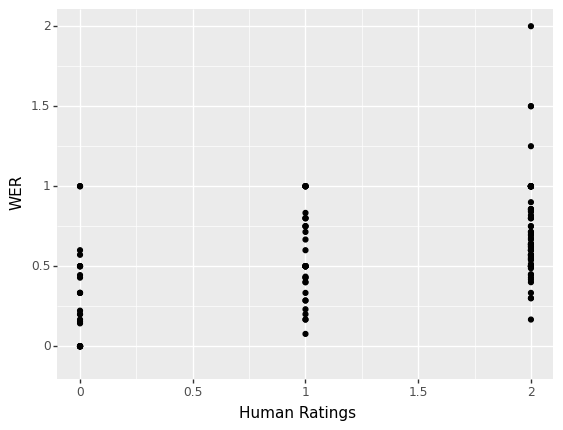

<ggplot: (8760126705770)>

In [50]:
plot_hu_mpn = (p9.ggplot(data=measures_df,
           mapping=p9.aes(x='Human', y='WER'))
    + p9.geom_point()
    + p9.xlab("Human Ratings")
    + p9.ylab("WER")
#     + p9.geom_smooth(method='lm')
    + p9.scales.ylim(-0.1,2)
#     + p9.themes.element_text(size=1)
)

plot_hu_mpn
# plot_hu_mpn.save("hu_wer.png")

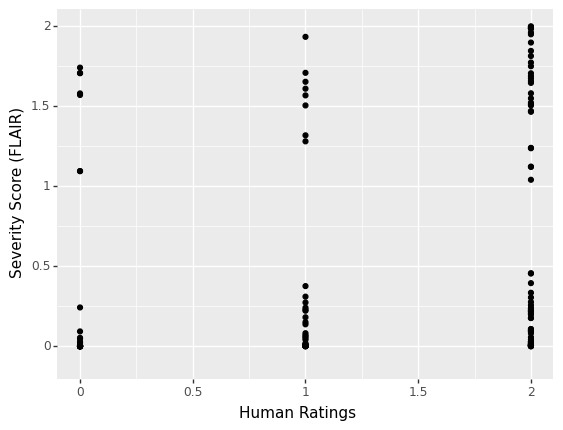

<ggplot: (8760126749118)>

In [51]:
plot_hu_mpn = (p9.ggplot(data=measures_df,
           mapping=p9.aes(x='Human', y='FLAIR_DS'))
    + p9.geom_point()
    + p9.xlab("Human Ratings")
    + p9.ylab("Severity Score (FLAIR)")
#     + p9.geom_smooth(method='lm')
    + p9.scales.ylim(-0.1,2)
#     + p9.themes.element_text(size=1)
)

plot_hu_mpn
# plot_hu_mpn.save("hu_flair.png")

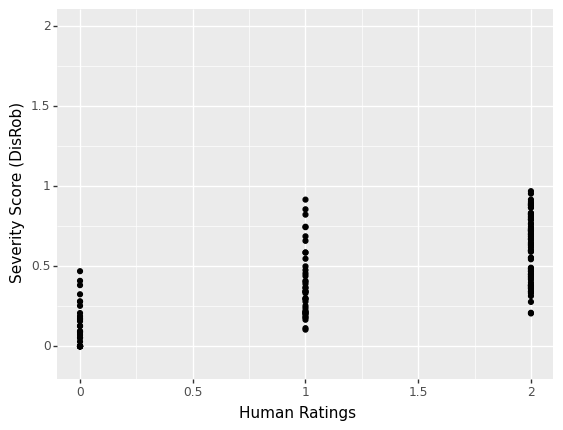

<ggplot: (8760126851684)>

In [52]:
plot_hu_mpn = (p9.ggplot(data=measures_df,
           mapping=p9.aes(x='Human', y='DisRob'))
    + p9.geom_point()
    + p9.xlab("Human Ratings")
    + p9.ylab("Severity Score (DisRob)")
#     + p9.geom_smooth(method='lm')
    + p9.scales.ylim(-0.1,2)
#     + p9.themes.element_text(size=1)
)

plot_hu_mpn
# plot_hu_mpn.save("hu_disrob.png")

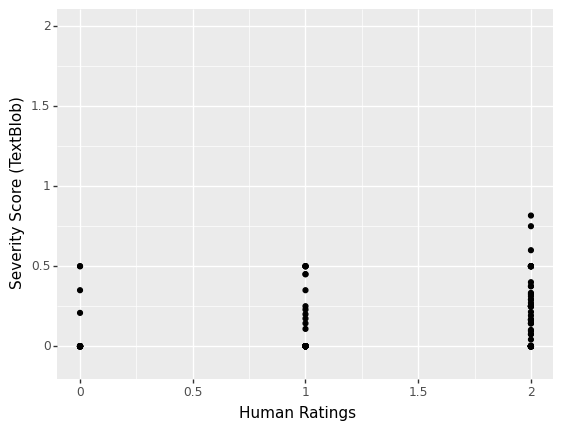

<ggplot: (8760126946699)>

In [53]:
# NLTK_DS	FLAIR_DS	TB_DS
plot_hu_mpn = (p9.ggplot(data=measures_df,
           mapping=p9.aes(x='Human', y='TB_DS'))
    + p9.geom_point()
    + p9.xlab("Human Ratings")
    + p9.ylab("Severity Score (TextBlob)")
#     + p9.geom_smooth(method='lm')
    + p9.scales.ylim(-0.1,2)
#     + p9.themes.element_text(size=1)
)

plot_hu_mpn
# plot_hu_mpn.save("imgs/hu_TB_DS.png")

In [57]:
fig = px.scatter(
    measures_df, x="Human", y="WER", 
    trendline="ols",
    labels={'x':'Human Rating', 'y':'DisRob Rating'},
    title='Human Rating vs DisRob Rating',
    hover_name=measures_df['pairs']
)
fig.show()

In [56]:
fig = px.scatter(
    measures_df, x="Human", y="DisRob", 
    trendline="ols",
    labels={'x':'Human Rating', 'y':'DisRob Rating'},
    title='Human Rating vs DisRob Rating',
    hover_name=measures_df['pairs']
)
fig.show()

## Ordinal Logistic Regression

In [23]:
import scipy.stats as stats

from statsmodels.miscmodels.ordinal_model import OrderedModel


In [85]:
mod_prob_DisRob = OrderedModel(measures_df['Human'],
                        measures_df[['DisRob']],
                        distr='logit')

In [86]:
res_log_DisRob = mod_prob_DisRob.fit(method='bfgs')


Optimization terminated successfully.
         Current function value: 0.690532
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17


In [87]:
res_log_DisRob.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  Human   Log-Likelihood:                -103.58
Model:                   OrderedModel   AIC:                             213.2
Method:            Maximum Likelihood   BIC:                             222.2
Date:                Mon, 19 Dec 2022                                         
Time:                        11:33:32                                         
No. Observations:                 150                                         
Df Residuals:                     147                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DisRob         8.0212      1.026      7.822      0.000       6.011      10.031
0.0/1.0        1.3504      0.361      3.745      0.000       0.644       2.057
1.0/2.0        0.7931      0.147      5.398      0.000       0.505       1.081
==============================================================================
"""

In [88]:
mod_prob_wer = OrderedModel(measures_df['Human'],
                        measures_df[['WER']],
                        distr='logit')

In [89]:
res_log_wer = mod_prob_wer.fit(method='bfgs')
res_log_wer.summary()

Optimization terminated successfully.
         Current function value: 0.865833
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  Human   Log-Likelihood:                -129.87
Model:                   OrderedModel   AIC:                             265.7
Method:            Maximum Likelihood   BIC:                             274.8
Date:                Mon, 19 Dec 2022                                         
Time:                        11:33:33                                         
No. Observations:                 150                                         
Df Residuals:                     147                                         
Df Model:                           3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WER            4.0187      0.639      6.290      0.000       2.766       5.271
0.0/1.0        0.7955      0.358      2.225      0.026       0.095       1.496
1.0/2.0        0.4706      0.146      3.227      0.001       0.185       0.756
==============================================================================
"""

In [90]:
predicted_dis = res_log_DisRob.model.predict(res_log_DisRob.params, exog=measures_df[['DisRob']])
predicted_wer = res_log_wer.model.predict(res_log_wer.params, exog=measures_df[['WER']])


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [93]:
predicted_wer.argmax(axis=1)

array([2, 1, 1, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 0, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2,
       0, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [94]:
np.mean(measures_df['Human'] == predicted_wer.argmax(axis=1))

0.6133333333333333

In [95]:
np.mean(measures_df['Human'] == predicted_dis.argmax(axis=1))

0.7133333333333334

## KFold cross validation

In [35]:
from sklearn.model_selection import KFold

k=10
splits=KFold(n_splits=k,shuffle=True,random_state=1)
fold_perf ={
    'DisRob_Acc': [],
    'MP_Acc': [],
    'MiniLM_Acc': [],
    'BERTNLI_Acc': [],
    'Flair_Acc': [],
    'WER_Acc': [],
    'Majority_Acc': []
}


In [123]:
for train_index, test_index in splits.split(measures_df):
    # get split    
    train, test = measures_df.iloc[train_index], measures_df.iloc[test_index]
    print('got split')
    # train and fit     
    mod_prob_DisRob = OrderedModel(train['Human'],
                        train[['DisRob']],
                        distr='logit')
    res_log_DisRob = mod_prob_DisRob.fit(method='bfgs')
    
    mod_prob_MP = OrderedModel(train['Human'],
                        train[['MPNET']],
                        distr='logit')
    res_log_MP = mod_prob_MP.fit(method='bfgs')
    
    mod_prob_BERT = OrderedModel(train['Human'],
                        train[['BertNLI']],
                        distr='logit')
    res_log_BERT = mod_prob_BERT.fit(method='bfgs')
    
    mod_prob_MINI = OrderedModel(train['Human'],
                        train[['MiniLM']],
                        distr='logit')
    res_log_MINI = mod_prob_MINI.fit(method='bfgs')
    
    mod_prob_Flair = OrderedModel(train['Human'],
                        train[['FLAIR_DS']],
                        distr='logit')
    res_log_Flair = mod_prob_Flair.fit(method='bfgs')

    
    mod_prob_wer = OrderedModel(train['Human'],
                        train[['WER']],
                        distr='logit')
    res_log_wer = mod_prob_wer.fit(method='bfgs')

    # predict test set     
    predicted_dis = res_log_DisRob.model.predict(res_log_DisRob.params, exog=test[['DisRob']])
    predicted_mp = res_log_MP.model.predict(res_log_MP.params, exog=test[['MPNET']])
    predicted_bert = res_log_BERT.model.predict(res_log_BERT.params, exog=test[['BertNLI']])
    predicted_mini = res_log_MINI.model.predict(res_log_MINI.params, exog=test[['MiniLM']])
    
    predicted_flair = res_log_Flair.model.predict(res_log_Flair.params, exog=test[['FLAIR_DS']])
    predicted_wer = res_log_wer.model.predict(res_log_wer.params, exog=test[['WER']])
    predict_majority = np.repeat(train['Human'].mode()[0], len(test['Human']))
    
    fold_perf['DisRob_Acc'].append(np.mean(test['Human'] == predicted_dis.argmax(axis=1)))
    fold_perf['MP_Acc'].append(np.mean(test['Human'] == predicted_mp.argmax(axis=1)))
    fold_perf['BERTNLI_Acc'].append(np.mean(test['Human'] == predicted_bert.argmax(axis=1)))
    fold_perf['MiniLM_Acc'].append(np.mean(test['Human'] == predicted_mini.argmax(axis=1)))
    
    fold_perf['Flair_Acc'].append(np.mean(test['Human'] == predicted_flair.argmax(axis=1)))
    fold_perf['WER_Acc'].append(np.mean(test['Human'] == predicted_wer.argmax(axis=1)))
    fold_perf['Majority_Acc'].append(np.mean(test['Human'] == predict_majority))
 

got split
Optimization terminated successfully.
         Current function value: 0.662727
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.727092
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.821077
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.725716
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.004455
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.867178
         Iterations: 15
         Function evaluati

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.993580
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.858813
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.678483
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.727421
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.804182
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.750375
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 0.991990
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.854464
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.713554
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.770370
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.858655
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.787959
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 1.022289
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.901987
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.689681
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.752898
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.831608
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.766987
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.999299
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.847773
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.712068
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.751267
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.802540
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.768918
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 1.015574
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.870585
         Iterations: 15
         Function evaluations: 16
  

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 1.006524
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.853387
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.698914
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.734293
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.811404
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.745143
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.993789
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.877669
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.678968
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.705900
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.806675
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: 0.731089
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.996751
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.866992
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
got split
Optimization terminated successfully.
         Current function value: 0.687150
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

Optimization terminated successfully.
         Current function value: 0.734237
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.826367
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.758857
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.982171
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.851818
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be 

In [124]:
np.mean(fold_perf['DisRob_Acc'])

0.7066666666666667

In [125]:
np.mean(fold_perf['WER_Acc'])

0.6199999999999999

In [126]:
np.mean(fold_perf['Flair_Acc'])

0.5

In [127]:
np.mean(fold_perf['Majority_Acc'])

0.5

In [128]:
np.mean(fold_perf['MP_Acc'])

0.6666666666666667

In [129]:
np.mean(fold_perf['MiniLM_Acc'])

0.66

In [121]:
np.mean(fold_perf['BERTNLI_Acc'])

0.6333333333333333

# Combining WER w/lang model

In [28]:
mod_prob_wer_DisRob = OrderedModel(measures_df['Human'],
                        measures_df[['WER', 'DisRob']],
                        distr='logit')


In [29]:
res_log_wer_DisRob = mod_prob_wer_DisRob.fit(method='bfgs')
res_log_wer_DisRob.summary()


Optimization terminated successfully.
         Current function value: 0.689925
         Iterations: 24
         Function evaluations: 25
         Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  Human   Log-Likelihood:                -103.49
Model:                   OrderedModel   AIC:                             215.0
Method:            Maximum Likelihood   BIC:                             227.0
Date:                Tue, 17 Jan 2023                                         
Time:                        11:10:02                                         
No. Observations:                 150                                         
Df Residuals:                     146                                         
Df Model:                           4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WER            0.3492      0.820      0.426      0.670      -1.257       1.956
DisRob         7.7374      1.217      6.359      0.000       5.353      10.122
0.0/1.0        1.4307      0.410      3.486      0.000       0.626       2.235
1.0/2.0        0.7934      0.147      5.404      0.000       0.506       1.081
==============================================================================
"""

In [33]:
predicted_dis = res_log_wer_DisRob.model.predict(res_log_wer_DisRob.params, exog=measures_df[['WER', 'DisRob']])
predicted_dis
np.mean(measures_df['Human'] == predicted_dis.argmax(axis=1))

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


0.72

In [41]:
combined_arr = []
for train_index, test_index in splits.split(measures_df):
    # get split    
    train, test = measures_df.iloc[train_index], measures_df.iloc[test_index]
    print('got split')
    # train and fit     
    mod_prob_DisRob = OrderedModel(train['Human'],
                        train[['WER', 'DisRob', 'FLAIR_DS']],
                        distr='logit')
    res_log_DisRob = mod_prob_DisRob.fit(method='bfgs')

    # predict test set     
    predicted_dis = res_log_DisRob.model.predict(res_log_DisRob.params, exog=test[['WER', 'DisRob', 'FLAIR_DS']])
    
    combined_arr.append(np.mean(test['Human'] == predicted_dis.argmax(axis=1)))

 

got split
Optimization terminated successfully.
         Current function value: 0.662421
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
got split
Optimization terminated successfully.
         Current function value: 0.708896
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


got split
Optimization terminated successfully.
         Current function value: 0.676411
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
got split
Optimization terminated successfully.
         Current function value: 0.712928
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
got split


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Optimization terminated successfully.
         Current function value: 0.686324
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
got split
Optimization terminated successfully.
         Current function value: 0.710276
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28
got split


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Optimization terminated successfully.
         Current function value: 0.663110
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
got split
Optimization terminated successfully.
         Current function value: 0.698609
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
got split
Optimization terminated successfully.
         Current function value: 0.676264
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


got split
Optimization terminated successfully.
         Current function value: 0.686223
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


In [42]:
np.mean(combined_arr)

0.7266666666666667

In [43]:
combined_arr

[0.6666666666666666,
 0.7333333333333333,
 0.6666666666666666,
 0.8666666666666667,
 0.7333333333333333,
 0.8,
 0.6,
 0.8,
 0.6666666666666666,
 0.7333333333333333]